# Modify intake catalog for Pangeo's CMIP6 collection to use OSDF

- This notebook uses pangeo's intake catalog https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json and modifies the zstore column to access the same data from the AWS open data origin via the OSDF protocol.

In [1]:
# Display output of plots directly in Notebook
import matplotlib.pyplot as plt
import intake
import numpy as np
#import pandas as pd
import xarray as xr
import intake_esm
import glob
from ecgtools import Builder
from ecgtools.builder import INVALID_ASSET, TRACEBACK
import re
import pandas as pd
from pathlib import Path
import aiohttp
import s3fs

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [3]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import OSDFFileSystem,PelicanMap 

In [4]:
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
rda_data    = '/gpfs/csfs1/collections/rda/data/'
#
s3_protocol   = 's3://'
osdf_protocol = 'osdf:///aws-opendata/us-west-2/'
#
rda_url       =  'https://data.rda.ucar.edu/'
osdf_url      = 'osdf:///ncar/rda/' 
#
newcat_osdf  = rda_data + 'harshah/intake_catalogs/cmip6-aws/'
newcat_csv   = rda_url +  'harshah/intake_catalogs/cmip6-aws/cmip6-osdf-zarr.csv'
newcat_url   = rda_url +  'harshah/intake_catalogs/cmip6-aws/cmip6-osdf-zarr.json'
#
print(newcat_url)

https://data.rda.ucar.edu/harshah/intake_catalogs/cmip6-aws/cmip6-osdf-zarr.json


In [5]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '4GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=4GB',
    queue = 'casper',
    walltime = '1:00:00',
    log_directory = rda_scratch+'/dask/logs',
    #interface = 'ib0'
    interface = 'ext'
)

In [6]:
cluster.scale(2)

In [7]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.96:35763,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Open catalogs

In [8]:
cat = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')
cat

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,522217
dcpp_init_year,60


In [9]:
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ta,gn,s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tauv,gn,s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,zg,gn,s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,vas,gn,s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
522212,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,uas,gr,s3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/...,NaN,20211207
522213,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,va,gr,s3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/...,NaN,20211207
522214,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,wap,gr,s3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/...,NaN,20211207
522215,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,s3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/...,NaN,20211207


In [10]:
cat.df['zstore'].values

array(['s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/ta/gn/v20170706/',
       's3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/tauv/gn/v20170706/',
       's3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-present/r1i1p1f1/Amon/zg/gn/v20170706/',
       ...,
       's3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/r1i1p1f1/Amon/wap/gr/v20211207/',
       's3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/r1i1p1f1/Amon/tas/gr/v20211207/',
       's3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/r1i1p1f1/Amon/vas/gr/v20211207/'],
      dtype=object)

In [11]:
# Connect to AWS S3 storage
fs = s3fs.S3FileSystem(anon=True)

# create a MutableMapping from a store URL
mapper = fs.get_mapper("s3://cmip6-pds/CMIP6/CMIP/AS-RCEC/TaiESM1/1pctCO2/r1i1p1f1/Amon/hfls/gn/v20200225/")

# make sure to specify that metadata is consolidated
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset> Size: 398MB
Dimensions:    (time: 1800, lat: 192, lon: 288, bnds: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 14kB 0001-01-16 12:00:00 ... 0150-12-16 12:00:00
    time_bnds  (time, bnds) object 29kB dask.array<chunksize=(1800, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    hfls       (time, lat, lon) float32 398MB dask.array<chunksize=(292, 192, 288), meta=np.ndarray>
Attributes: (12/53)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 0701-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     182500.0
    ...                        ...
    title:                     TaiESM1 output prepared for CMIP6
    tracking_id:               hdl:21.14100/813dbc9a-249f-4cde-a56c-fea0a42a5eb5
    variable_id:               hfls
    variant_label:             r1i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/813dbc9a-249f-4cde-a56c-fea0a42a5eb5
    version_id:                v20200225

In [12]:
# Initiate OSDF file system 
osdf_fs   = OSDFFileSystem(direct_reads = True) # OSDFFileSystem is already aware of the osdf discovery url
# zarr_path = '/aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLNS.zarr'
zarr_path = '/aws-opendata/us-west-2/cmip6-pds/CMIP6/CMIP/AS-RCEC/TaiESM1/1pctCO2/r1i1p1f1/Amon/hfls/gn/v20200225/'
#
pel_zarr  = PelicanMap(zarr_path, osdf_fs)
ds_test   = xr.open_zarr(pel_zarr)
ds_test

<xarray.Dataset> Size: 398MB
Dimensions:    (time: 1800, lat: 192, lon: 288, bnds: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 14kB 0001-01-16 12:00:00 ... 0150-12-16 12:00:00
    time_bnds  (time, bnds) object 29kB dask.array<chunksize=(1800, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    hfls       (time, lat, lon) float32 398MB dask.array<chunksize=(292, 192, 288), meta=np.ndarray>
Attributes: (12/53)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 0701-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     182500.0
    ...                        ...
    title:                     TaiESM1 output prepared for CMIP6
    tracking_id:               hdl:21.14100/813dbc9a-249f-4cde-a56c-fea0a42a5eb5
    variable_id:               hfls
    variant_label:             r1i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/813dbc9a-249f-4cde-a56c-fea0a42a5eb5
    version_id:                v20200225

### Create catalog for osdf access, change the csv and json files and save

In [13]:
df_osdf            = cat.df
df_osdf['zstore']  = df_osdf['zstore'].str.replace(s3_protocol, osdf_protocol)
df_osdf

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ta,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tauv,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,zg,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,vas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
522212,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,uas,gr,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20211207
522213,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,va,gr,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20211207
522214,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,wap,gr,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20211207
522215,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20211207


In [14]:
# df_osdf['zstore'].values

In [15]:
# %%time
# print(newcat_osdf +'cmip6-osdf-zarr.csv')
# #
# df_osdf.to_csv(newcat_osdf +'cmip6-osdf-zarr.csv',index=False)

#### Do not forget to update the csv path in the associated json file. 
- You will need to edit the 'catalog_file' column!
- Intake ESM doesnot recognize the osdf protocol. So, the path to the osdf catalag csv file has to be a https link

### Open and test all catalogs

In [16]:
#
print(newcat_url)

https://data.rda.ucar.edu/harshah/intake_catalogs/cmip6-aws/cmip6-osdf-zarr.json


In [17]:
df_osdf_test= intake.open_esm_datastore(newcat_url)
df_osdf_test.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ta,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tauv,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,zg,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,vas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
522212,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,uas,gr,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20211207
522213,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,va,gr,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20211207
522214,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,wap,gr,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20211207
522215,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20211207


## Select a variable and make sure data can be loaded using each catalog
- We use surface air temperature, tas

In [18]:
######
data_var    = 'tas'
variable_id = 'tas' # Surface Air Temperature
table_id    = 'Amon' # Monthly data from Atmosphere
grid        = 'gn' #

# Records for Institution, experiment, and source_id are stored in https://github.com/WCRP-CMIP/CMIP6_CVs
experiment_ids = ['historical', 'ssp370', 'ssp585']
activity_ids   = ['CMIP'] # Search Scenarios & Historical data only
institution_id = 'NASA-GISS'
source_id      = ['GISS-E2-1-G']

#
col_subset_osdf  = df_osdf_test.search(variable_id=data_var,activity_id=activity_ids, institution_id=institution_id,\
                                       experiment_id=experiment_ids, source_id=source_id, table_id=table_id)
##
col_subset_osdf 

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,46
table_id,1
variable_id,1
grid_label,1
zstore,46
dcpp_init_year,0


In [19]:
dsets_osdf  = col_subset_osdf.to_dataset_dict()
print(f"\nDataset dictionary keys:\n {dsets_osdf.keys()}")

# Load the first dataset and display a summary.
dataset_key = list(dsets_osdf.keys())[0]
#
ds_osdf = dsets_osdf[dataset_key]
#
ds_osdf


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



Dataset dictionary keys:
 dict_keys(['CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn'])


<xarray.Dataset> Size: 5GB
Dimensions:         (member_id: 46, dcpp_init_year: 1, time: 1980, lat: 90,
                     lon: 144, bnds: 2)
Coordinates:
    height          float64 8B 2.0
  * lat             (lat) float64 720B -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
    lat_bnds        (lat, bnds) float64 1kB dask.array<chunksize=(90, 2), meta=np.ndarray>
  * lon             (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
    lon_bnds        (lon, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
    time_bnds       (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 368B 'r101i1p1f1' ... 'r9i1p5f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 600, 90, 144), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    cmor_version:                     3.3.2
    contact:                          Kenneth Lo (cdkkl@giss.nasa.gov)
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NASA-GISS.GISS-E2-1-G.historical.A...

CPU times: user 598 ms, sys: 209 ms, total: 807 ms
Wall time: 22.4 s


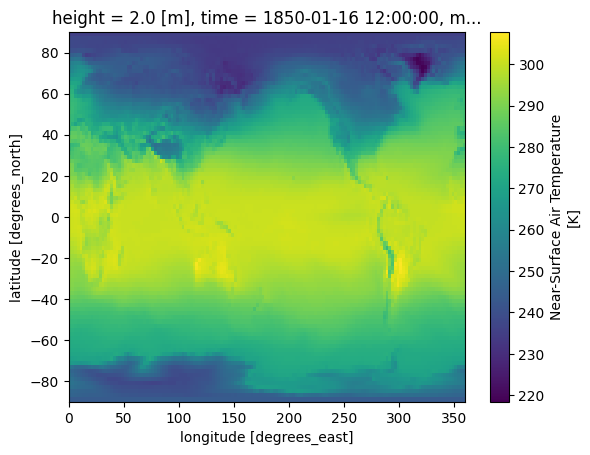

In [20]:
%%time
ds_osdf.tas.isel(member_id=0,dcpp_init_year=0,time=0).plot()